# Shelter 🐶 🐱 Adoptions

[Kaggle Competition](https://www.kaggle.com/c/shelter-animal-outcomes)

In [168]:
reset -fs

![pic](pr.JPG)

### Imports

In [169]:
from collections import Counter
from fractions import Fraction
from math import factorial
import itertools
import random

import pandas as pd
import numpy as np
import scipy.stats as stats 
from scipy.stats import norm
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
sns.set_style("dark", {'axes.grid' : False})
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [170]:
animals = pd.read_csv('data/train.csv')
animals.head(2)

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby


In [171]:
# rename columns
animals.columns = [x.lower() for x in animals.columns]
animals = animals.rename(index=str, 
                        columns={
                               "animalid": "id",
                               "datetime": "date_outcome",
                               "outcometype": "outcome",
                               "outcomesubtype": "outcome_info",
                               "animaltype": "animal",
                               "sexuponoutcome": "sex_outcome",
                               "ageuponoutcome": "age"})
animals.columns

Index(['id', 'name', 'date_outcome', 'outcome', 'outcome_info', 'animal',
       'sex_outcome', 'age', 'breed', 'color'],
      dtype='object')

### EDA

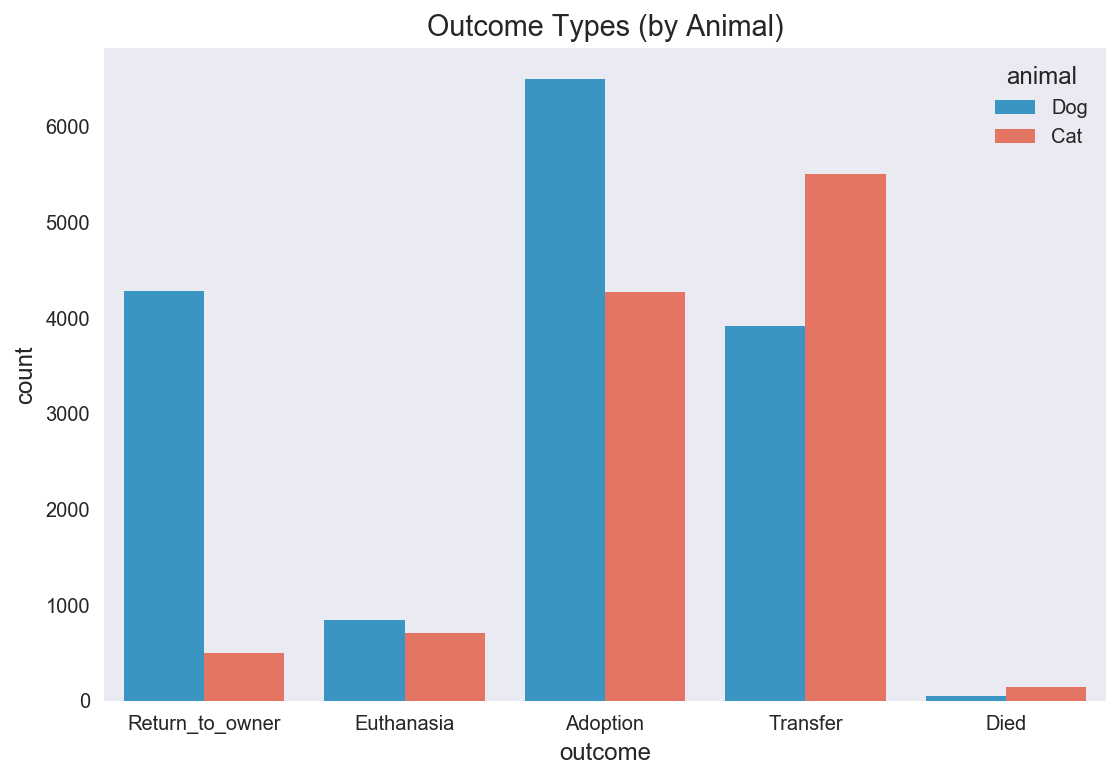

In [172]:
plt.subplots(figsize=(8, 6))
sns.countplot(x="outcome", 
              hue="animal", 
              data=animals, 
              alpha=0.85).set_title('Outcome Types (by Animal)');

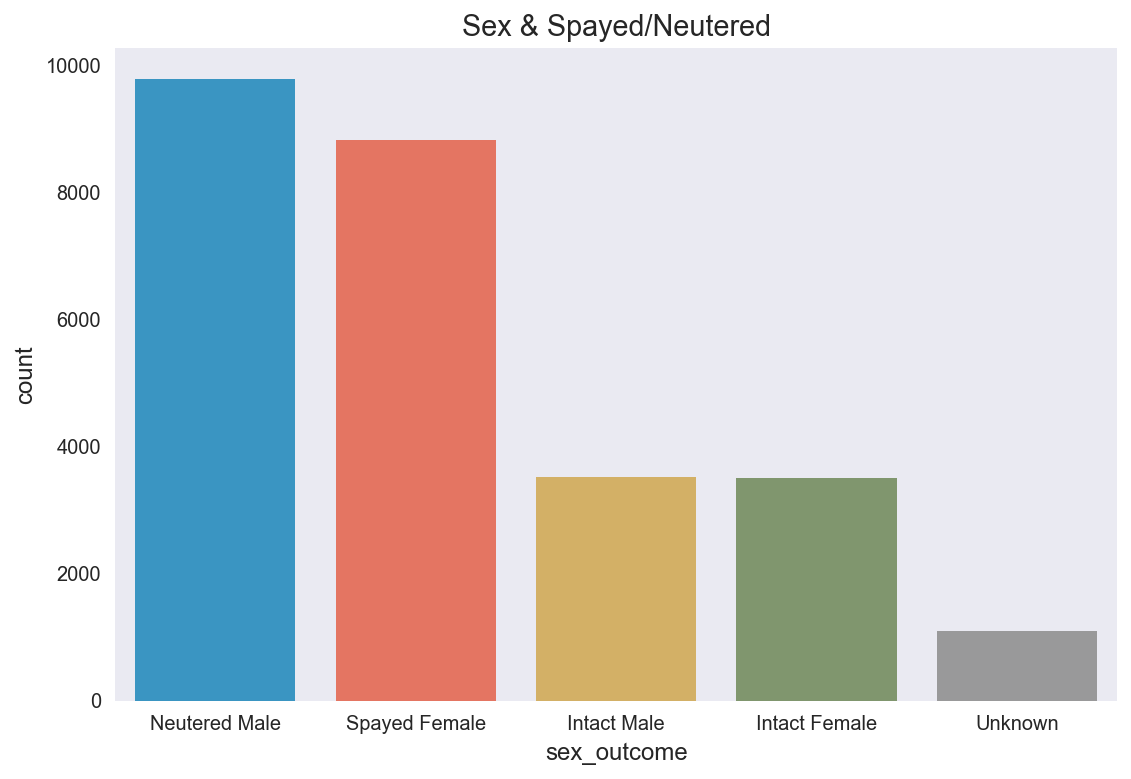

In [173]:
plt.subplots(figsize=(8, 6))
sns.countplot(x="sex_outcome", 
              data=animals, 
              alpha=0.85).set_title('Sex & Spayed/Neutered');

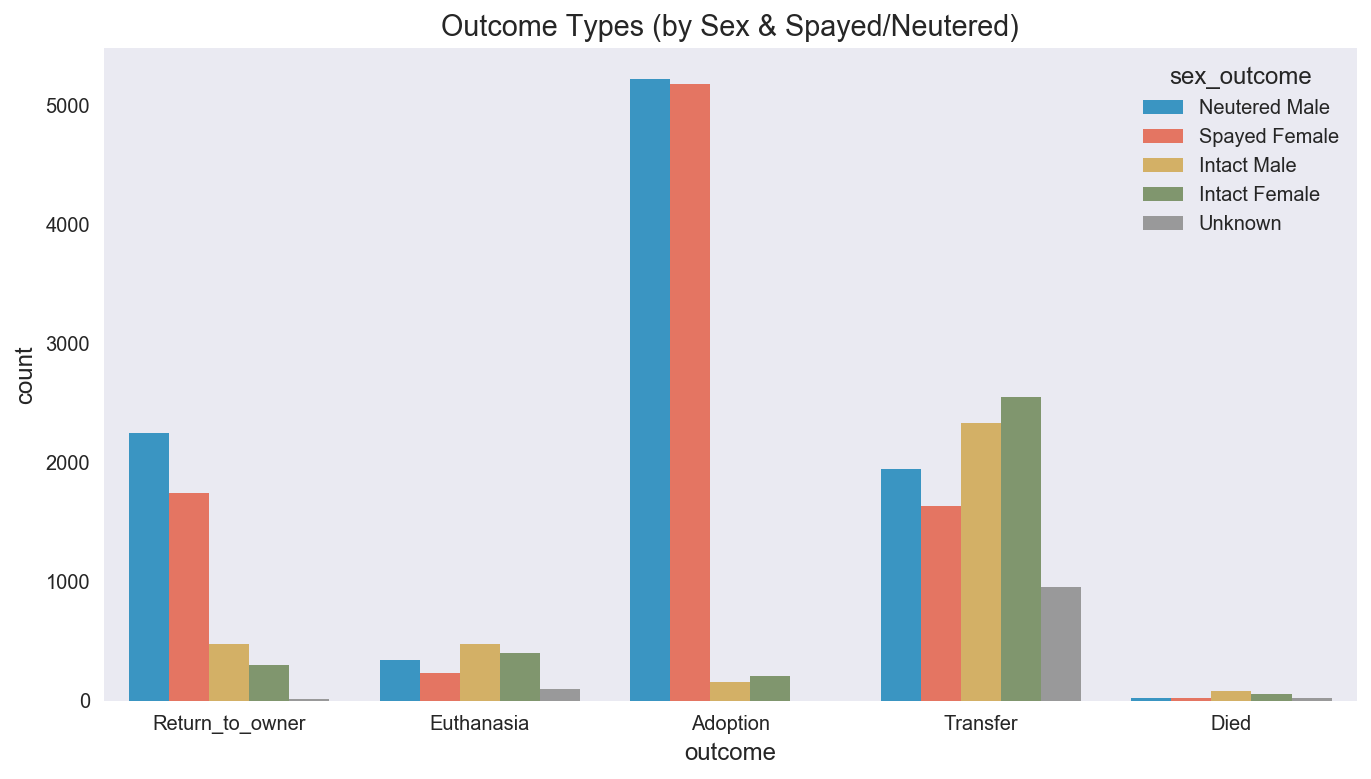

In [174]:
plt.subplots(figsize=(10, 6))
sns.countplot(x="outcome", 
              hue="sex_outcome", 
              data=animals, 
              orient="v",
              alpha=0.85).set_title('Outcome Types (by Sex & Spayed/Neutered)');

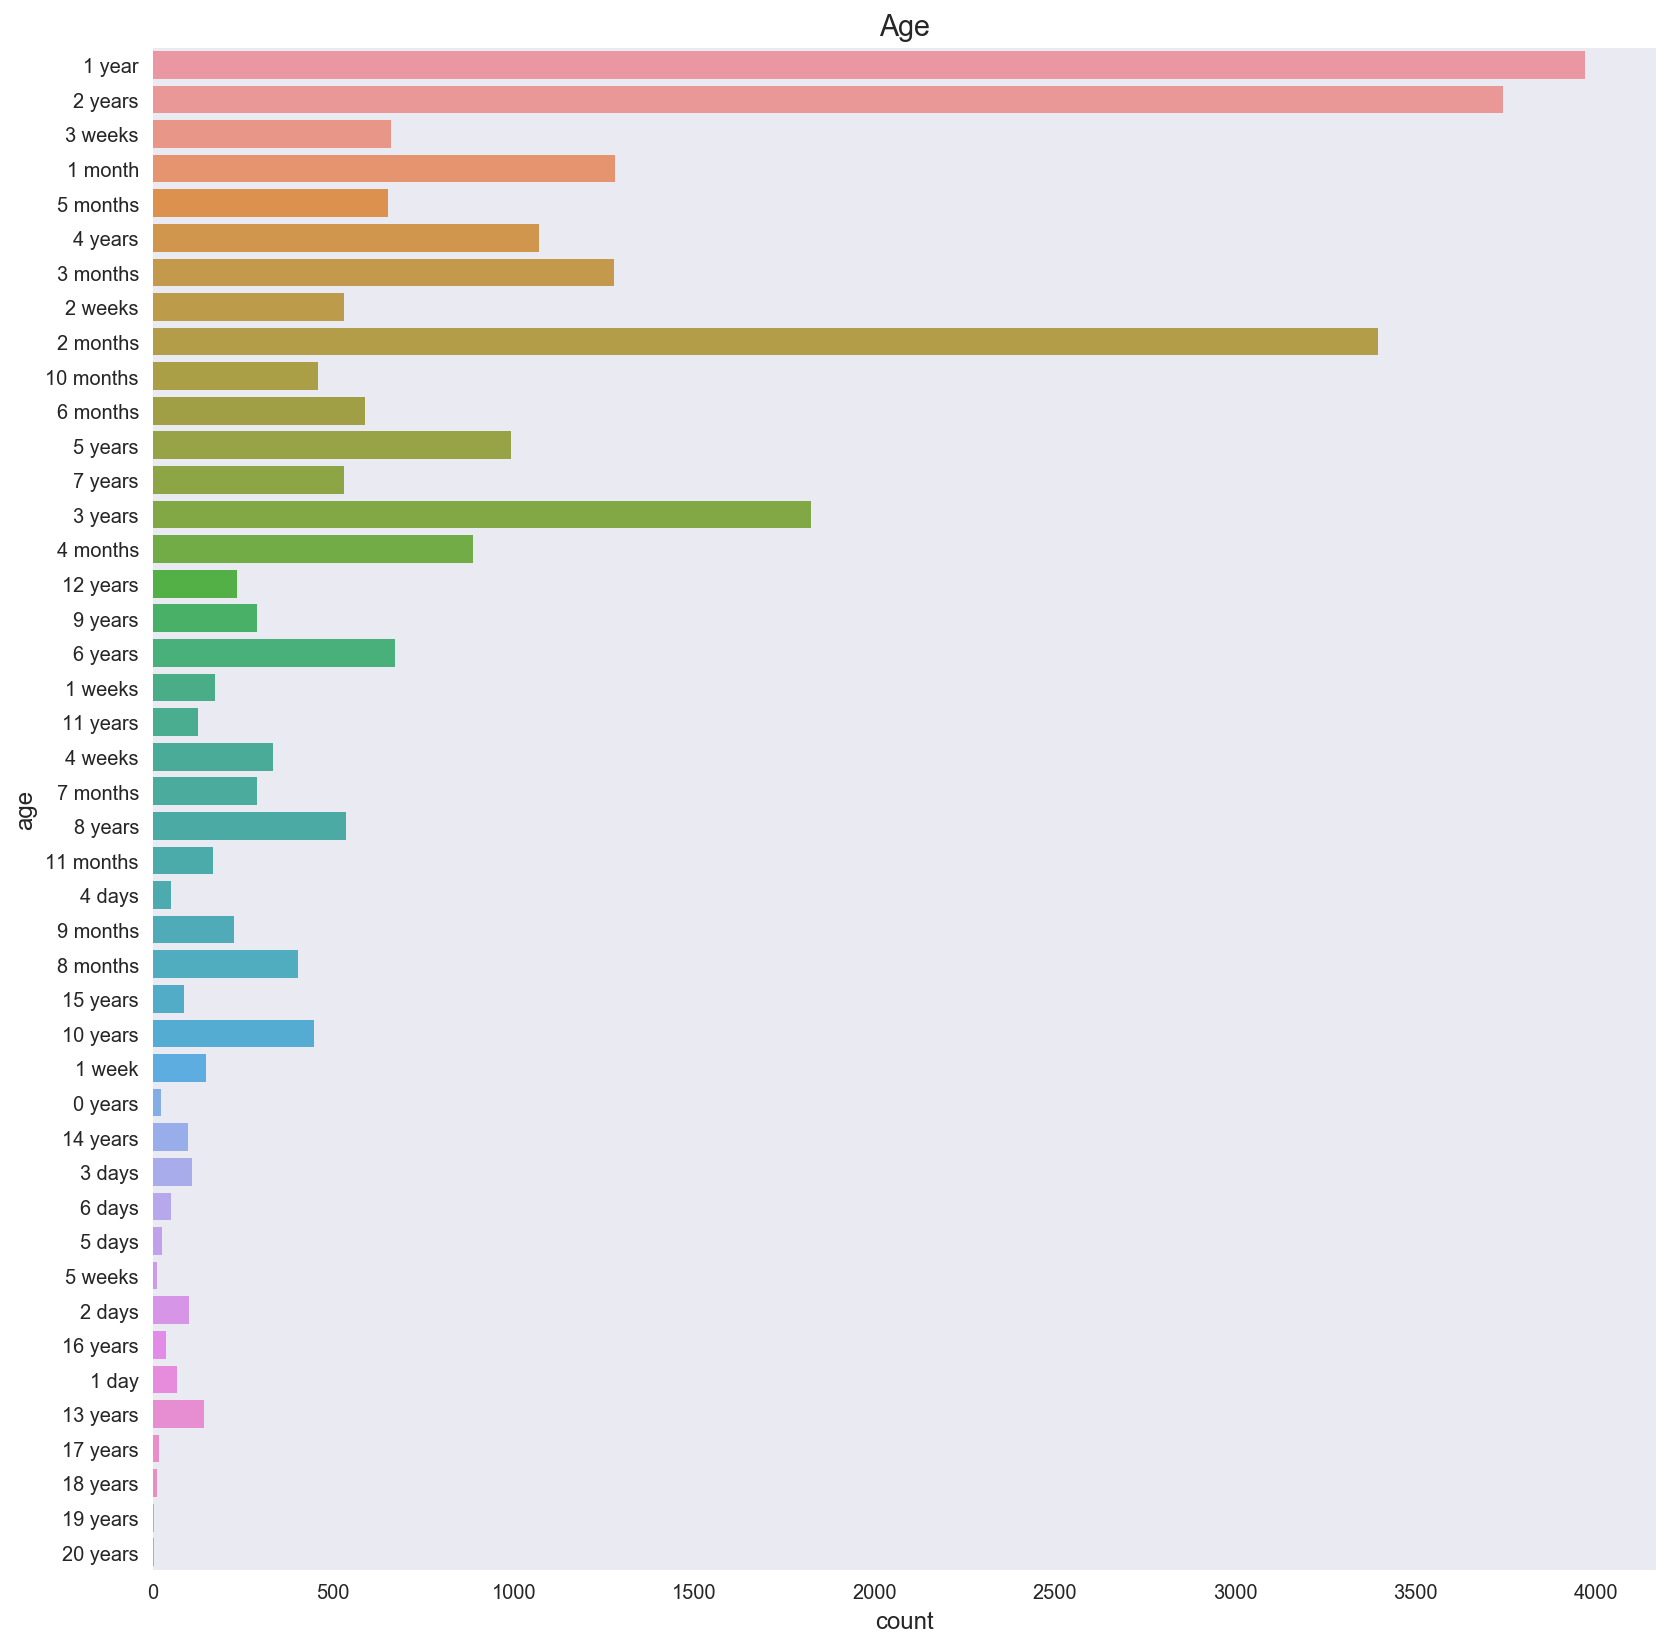

In [175]:
plt.subplots(figsize=(12,14))
sns.countplot(y="age", data=animals).set_title('Age');

### Animal
Make new column "dog"... 0 = 🐱, 1 = 🐶

In [176]:
animals.animal.value_counts()

Dog    15595
Cat    11134
Name: animal, dtype: int64

In [177]:
animals['dog'] = animals.animal.apply(lambda row: 0 if 'Cat' in row else 1)

In [178]:
animals.dog.value_counts()

1    15595
0    11134
Name: dog, dtype: int64

### Outcome
Keeping it simple and making this binary... 0 = not adopted 😢, 1 = adopted 😁

In [179]:
animals.outcome.value_counts(dropna=False)

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: outcome, dtype: int64

In [180]:
animals['adopted'] = animals.outcome.apply(lambda row: 1 if row == 'Adoption' else 0)

In [181]:
animals.adopted.value_counts(dropna=False)

0    15960
1    10769
Name: adopted, dtype: int64

### Hypothesis Test   
#### Null hypothesis is no difference between dog and cat adoptions
$ H_0:$ 🐶 adopted = 🐱 adopted

#### Alternative hypothesis is there are more dogs adopted than cats
$ H_a:$ 🐶 adopted > 🐱 adopted

In [182]:
n = animals.shape[0]
P_dog = animals[animals.dog == 1].shape[0]/n
P_cat = animals[animals.dog == 0].shape[0]/n

# get point estimate - difference between dog and cat 
pt_est = P_dog - P_cat

# standard deviation 
std = np.sqrt((P_dog*(1-P_dog)/n) + (P_cat*(1-P_cat)/n))

# z-score
z = pt_est / std

# p-value
pval = 1 - stats.norm.cdf(z)

print("p-value = {:.3f}".format(pval))

p-value = 0.000


We reject the null hypothesis because the p-value is less than α — the significance cuttoff of 0.05 since the alternative hypothesis states there are more dogs adopted than cats we look at the right tail. We never accept the alternative hypothesis but according to this analysis it's logical to conclude that more dogs are adopted than cats.

In [183]:
model_dog = smf.logit(formula='adopted ~ dog', data=animals).fit()
model_dog.summary()

Optimization terminated successfully.
         Current function value: 0.673620
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                adopted   No. Observations:                26729
Model:                          Logit   Df Residuals:                    26727
Method:                           MLE   Df Model:                            1
Date:                Fri, 10 Mar 2017   Pseudo R-squ.:               0.0008133
Time:                        12:41:43   Log-Likelihood:                -18005.
converged:                       True   LL-Null:                       -18020.
                                        LLR p-value:                 6.165e-08
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -0.4739      0.019    -24.317      0.000        -0.512    -0.436
dog            0.1372      0.025      5.408      0.000         0.087     0.187
==============================================================================
"""

### Name

Some animals come into the shelter with no name 😥 !! 
The presence of name may be a predictor variable — making a new column for this as well as top 10 most popular names.

In [184]:
# I guess people are not unique when naming their pets
len(animals.name.unique())

6375

In [185]:
animals.name.value_counts(dropna=False).head(11)

NaN         7691
Max          136
Bella        135
Charlie      107
Daisy        106
Lucy          94
Buddy         87
Princess      86
Rocky         85
Luna          68
Jack          66
Name: name, dtype: int64

In [186]:
# replace NaN with "unknown"
animals.name.replace(np.nan, 'unknown', inplace=True)
animals.name.value_counts(dropna=False).head(10)

unknown     7691
Max          136
Bella        135
Charlie      107
Daisy        106
Lucy          94
Buddy         87
Princess      86
Rocky         85
Luna          68
Name: name, dtype: int64

In [187]:
# create has_name column - 0 no name, 1 name
animals['has_name'] = animals.name.apply(lambda row: 0 if 'unknown' in row else 1)

In [188]:
top10 = [name for name in animals.name.value_counts().head(11).index.tolist() if name != 'unknown']

def popular_name(row):
    """returns indicator variable of top 10 most common animal names"""
    if row in top10:
        return 1 # True
    else:
        return 0 # False

#assert popular_name('Jack') == 1
assert popular_name('Jack')

In [189]:
animals['pop_name'] = animals.name.apply(popular_name)

In [190]:
animals.pop_name.value_counts()

0    25759
1      970
Name: pop_name, dtype: int64

In [191]:
model_names = smf.logit(formula='adopted ~ dog + has_name + pop_name', data=animals).fit()
model_names.summary()

Optimization terminated successfully.
         Current function value: 0.642990
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                adopted   No. Observations:                26729
Model:                          Logit   Df Residuals:                    26725
Method:                           MLE   Df Model:                            3
Date:                Fri, 10 Mar 2017   Pseudo R-squ.:                 0.04625
Time:                        12:41:52   Log-Likelihood:                -17186.
converged:                       True   LL-Null:                       -18020.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -1.2119      0.029    -41.753      0.000        -1.269    -1.155
dog           -0.1922      0.028     -6.974      0.000        -0.246    -0.138
has_name       1.2545      0.033     38.229      0.000         1.190     1.319
pop_name      -0.0446      0.066     -0.673      0.501        -0.175     0.085
==============================================================================
"""

### Sex and spayed/neutered
Create new columns for sex, spayed/neutered, also drop unknowns.

In [192]:
animals.sex_outcome.value_counts(dropna=False)

Neutered Male    9779
Spayed Female    8820
Intact Male      3525
Intact Female    3511
Unknown          1093
NaN                 1
Name: sex_outcome, dtype: int64

In [193]:
# make "Unknown" NaN for dropping
animals.sex_outcome.replace('Unknown', np.nan, inplace=True)

In [194]:
animals.shape

(26729, 14)

In [195]:
animals.dropna(subset=['sex_outcome'],inplace=True)
animals.reset_index(drop=True, inplace=True)

In [196]:
animals.shape

(25635, 14)

In [197]:
# create new columns for sex, spayed_neutered
animals['sex'] = animals.sex_outcome.apply(lambda row: 1 if 'Female' in row else 0)
animals['spay_neutered'] = animals.sex_outcome.apply(lambda row: 0 if 'Intact' in row else 1)

In [198]:
animals.sex.value_counts(dropna=False)

0    13304
1    12331
Name: sex, dtype: int64

In [199]:
animals.spay_neutered.value_counts(dropna=False)

1    18599
0     7036
Name: spay_neutered, dtype: int64

In [200]:
# woohoo Pseudo R-squared is 0.2
model_sex = smf.logit(formula='adopted ~ dog + has_name + pop_name + sex + spay_neutered', data=animals).fit()
model_sex.summary()

Optimization terminated successfully.
         Current function value: 0.544165
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                adopted   No. Observations:                25635
Model:                          Logit   Df Residuals:                    25629
Method:                           MLE   Df Model:                            5
Date:                Fri, 10 Mar 2017   Pseudo R-squ.:                  0.2001
Time:                        12:42:06   Log-Likelihood:                -13950.
converged:                       True   LL-Null:                       -17440.
                                        LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept        -2.8248      0.059    -47.730      0.000        -2.941    -2.709
dog              -0.6199      0.032    -19.629      0.000        -0.682    -0.558
has_name          0.0546      0.041      1.344      0.179        -0.025     0.134
pop_name         -0.1188      0.070     -1.694      0.090        -0.256     0.019
sex               0.2101      0.029      7.270      0.000         0.153     0.267
spay_neutered     3.3479      0.060     55.512      0.000         3.230     3.466
=================================================================================
"""

### Date of outcome
Convert string date to actual datetime format and create columns for time of day, weekday, month, season, and year.

In [201]:
# creates new column with datetime format of string
animals['datetime'] = pd.to_datetime(animals['date_outcome'], infer_datetime_format=True)

In [202]:
# new column for day: 0 = Monday, 6 = Sunday 
animals['day'] = animals['datetime'].apply(lambda row: row.weekday())

# new column for months: 1-12
animals['month'] = animals['datetime'].apply(lambda row: row.month)

# new column for years: 2013-2016
animals['year'] = animals['datetime'].apply(lambda row: row.year)

# new column for morning, afternoon, evening
animals['hour'] = animals['datetime'].apply(lambda row: row.hour)

# won't do anything with this - will just use to investigate when hour = 0
animals['minutes'] = animals['datetime'].apply(lambda row: row.minute)

In [203]:
animals.hour.value_counts(dropna=False).sort_index()

0      364
5        1
6        9
7      109
8      292
9     1057
10     375
11    1997
12    2442
13    2373
14    2670
15    2573
16    2612
17    4058
18    3562
19    1024
20      74
21      18
22       5
23      20
Name: hour, dtype: int64

In [204]:
# 00:00:00 is ambiguous and could be midnight or first thing in the morning 
# or even be a missing/wrongly entered value 
animals.datetime.value_counts().head(10)

2015-08-11 00:00:00    19
2015-11-17 00:00:00    17
2015-07-02 00:00:00    13
2015-04-02 00:00:00    11
2014-08-31 09:00:00    10
2015-11-23 00:00:00     9
2016-02-15 00:00:00     9
2015-09-11 00:00:00     9
2015-09-01 00:00:00     8
2015-11-08 00:00:00     8
Name: datetime, dtype: int64

In [205]:
# checking out 00:00:00 be
animals[['datetime', 'hour', 'minutes']][(animals['hour']==0) & (animals['minutes']==0)].head(10)

,datetime,hour,minutes
36,2015-08-11,0,0
110,2015-11-05,0,0
167,2015-09-01,0,0
173,2015-12-22,0,0
187,2015-09-01,0,0
239,2015-08-05,0,0
242,2016-02-07,0,0
278,2015-11-05,0,0
295,2015-11-23,0,0
395,2015-11-24,0,0


In [206]:
# so for hour = 0 there's only 3 rows where hour = 0 and minutes !=0 - I'll drop these rows
print(animals[(animals['hour']==0) & (animals['minutes']==0)].shape)
print(animals[(animals['hour']==0) & (animals['minutes']!=0)].shape)

(361, 22)
(3, 22)


In [207]:
# make "Unknown" NaN for dropping
animals.hour.replace(0, np.nan, inplace=True)

In [208]:
animals.dropna(subset=['hour'],inplace=True)

In [209]:
animals.hour.value_counts(dropna=False).sort_index(ascending=True)

5.0        1
6.0        9
7.0      109
8.0      292
9.0     1057
10.0     375
11.0    1997
12.0    2442
13.0    2373
14.0    2670
15.0    2573
16.0    2612
17.0    4058
18.0    3562
19.0    1024
20.0      74
21.0      18
22.0       5
23.0      20
Name: hour, dtype: int64

In [210]:
def time_of_day(row):
    """returns indicator variable for time of day based on hour"""
    if row >= 5 and row < 12:
        time = 'morning'
    elif row >= 12 and row < 17:
        time = 'afternoon'
    else:
        time = 'evening'
    return time

assert time_of_day(6) == 'morning'

In [211]:
# create new column for time of day
animals['time_of_day'] = animals.month.apply(time_of_day)

In [212]:
def season(row):
    """returns indicator variable for season based on month number"""
    if row == 3 or row == 4 or row == 5:
        season = 'spring'
    elif row == 6 or row == 7 or row == 8:
        season = 'summer'
    elif row == 9 or row == 10 or row == 11:
        season = 'fall'
    else:
        season = 'winter'
    return season

assert season(12) == 'winter'

In [213]:
# create new column for season
animals['season'] = animals.month.apply(season)

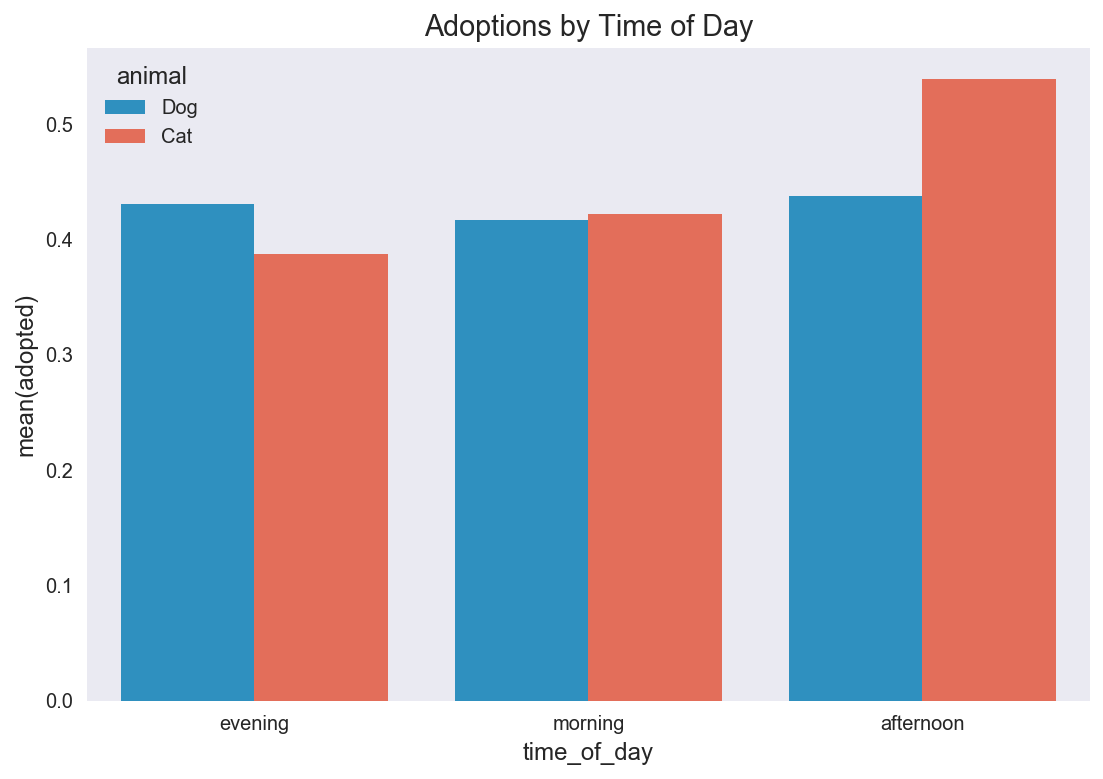

In [214]:
plt.subplots(figsize=(8, 6))
sns.barplot(x="time_of_day", 
            y="adopted", 
            hue='animal', 
            data=animals, 
            alpha=0.9, 
            ci = None).set_title('Adoptions by Time of Day');

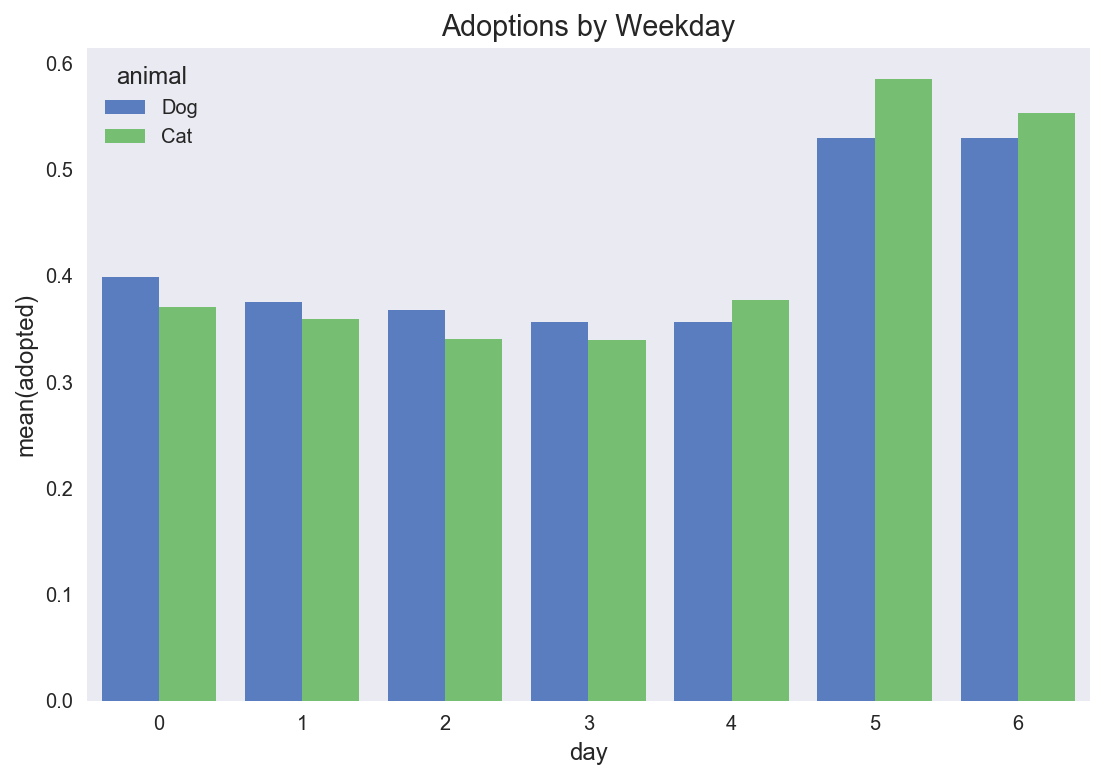

In [215]:
# reminder: Monday is 0, Sunday is 6
plt.subplots(figsize=(8, 6))
sns.barplot(x="day", 
            y="adopted", 
            hue="animal", 
            data=animals, 
            palette='muted', 
            ci = None).set_title('Adoptions by Weekday');

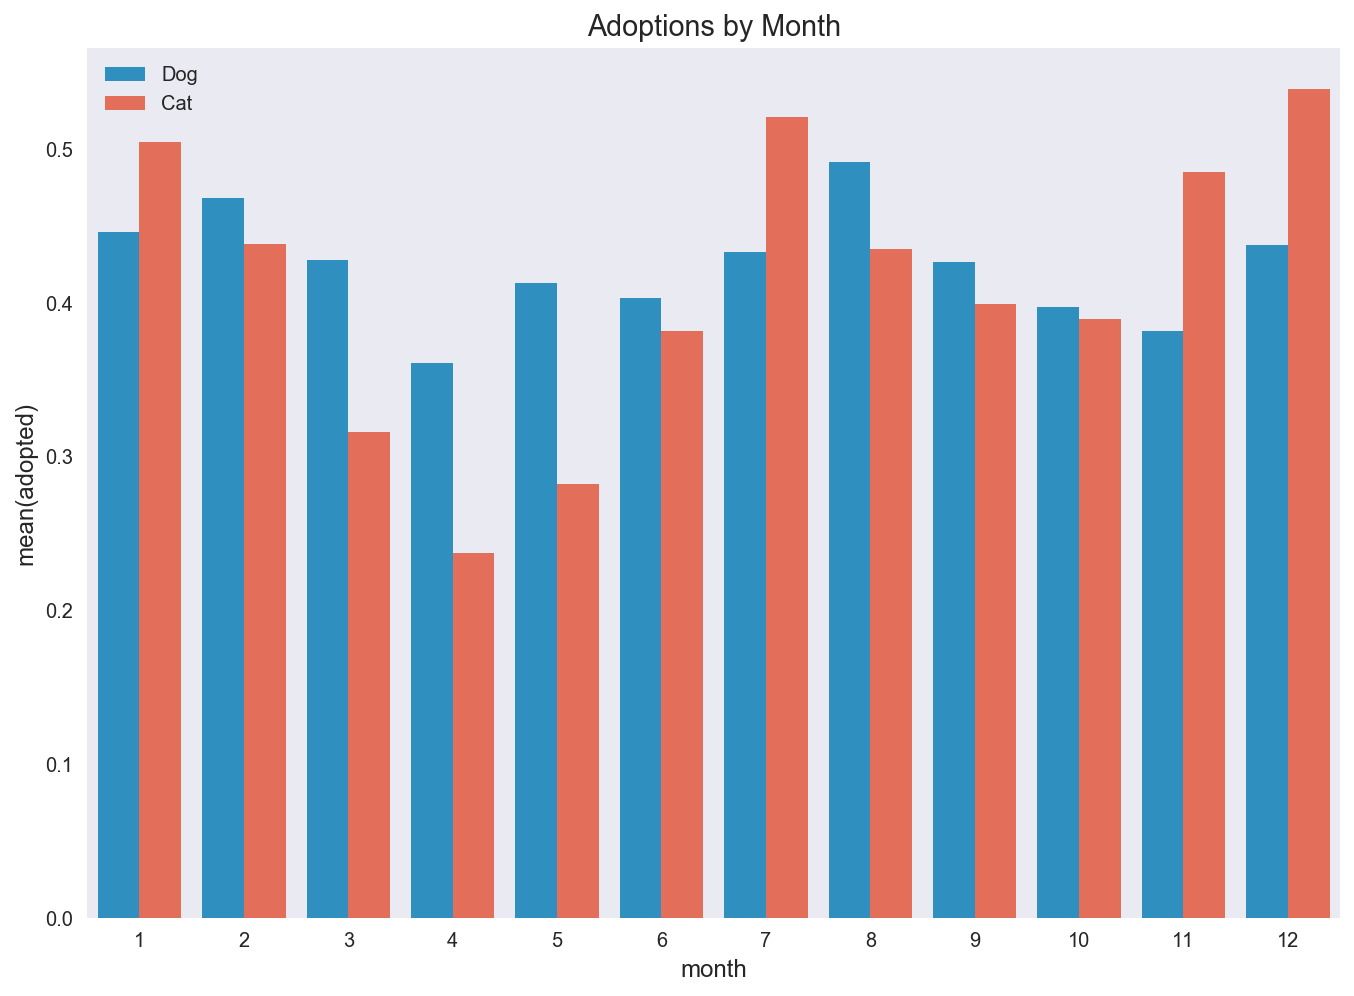

In [216]:
plt.subplots(figsize=(10, 8))
sns.barplot(x="month", 
            y="adopted", 
            hue="animal", 
            data=animals, 
            alpha=0.9, 
            ci = None).set_title('Adoptions by Month');
plt.legend(loc='upper left');

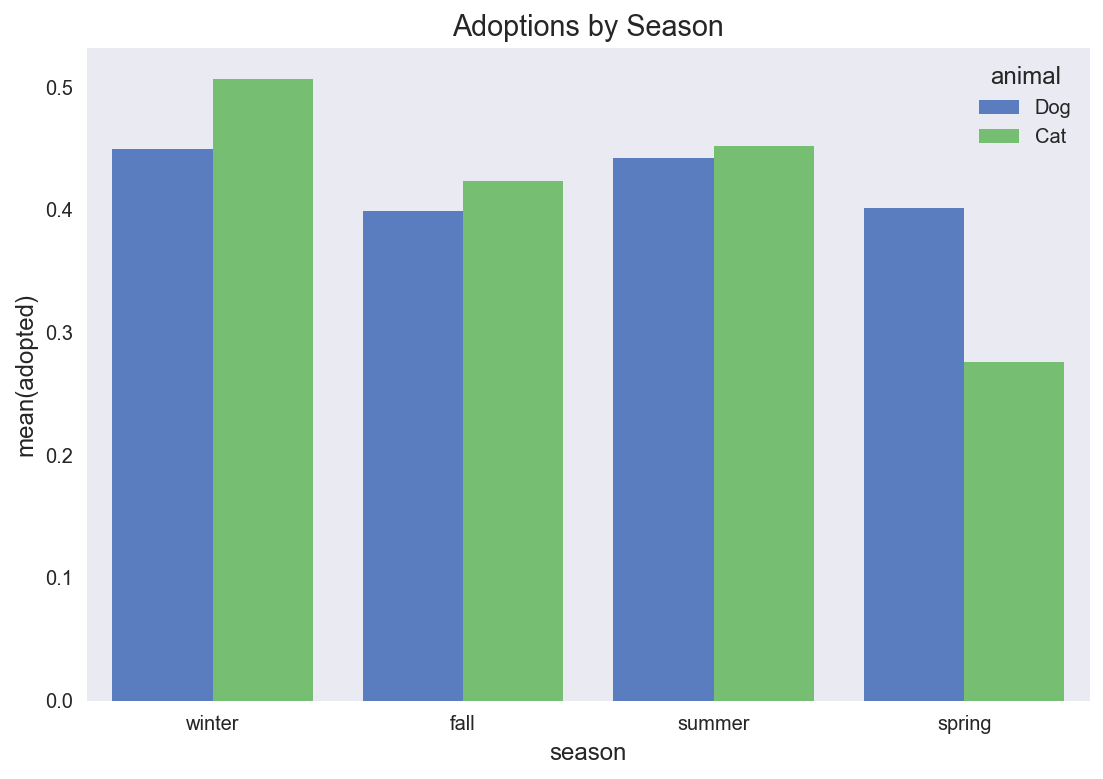

In [217]:
plt.subplots(figsize=(8, 6))
sns.barplot(x="season", 
            y="adopted", 
            hue="animal", 
            data=animals, 
            palette='muted', 
            ci = None).set_title('Adoptions by Season');

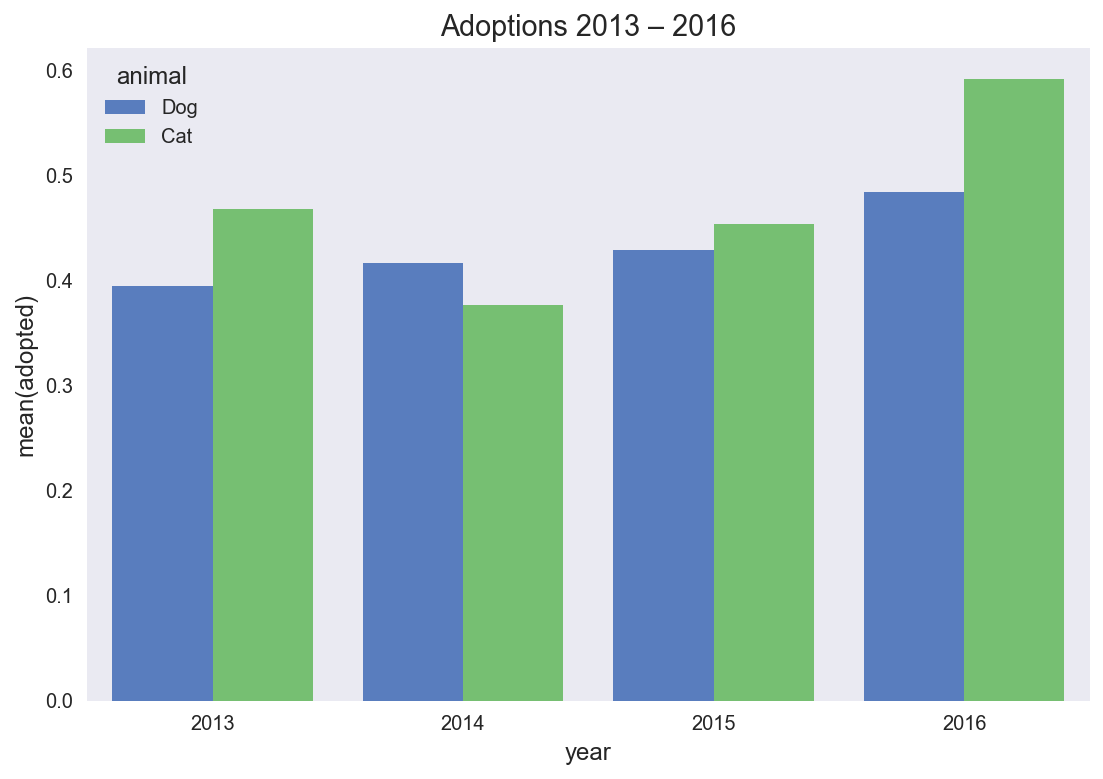

In [218]:
plt.subplots(figsize=(8, 6))
sns.barplot(x="year", 
            y="adopted", 
            hue="animal", 
            data=animals, 
            palette='muted', 
            ci = None).set_title('Adoptions 2013 – 2016');

In [219]:
# Pseudo R-squared increased ever so slightly but I've also added a good number of variables
model_time = smf.logit(formula='adopted ~ dog + has_name + pop_name + sex + spay_neutered + day + month + time_of_day + season', data=animals).fit()
model_time.summary()

Optimization terminated successfully.
         Current function value: 0.534253
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                adopted   No. Observations:                25271
Model:                          Logit   Df Residuals:                    25258
Method:                           MLE   Df Model:                           12
Date:                Fri, 10 Mar 2017   Pseudo R-squ.:                  0.2164
Time:                        12:42:24   Log-Likelihood:                -13501.
converged:                       True   LL-Null:                       -17229.
                                        LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
Intercept                 -3.7213      0.460     -8.097      0.000        -4.622    -2.821
time_of_day[T.evening]     0.0786      0.253      0.311      0.756        -0.416     0.574
time_of_day[T.morning]     0.2922      0.229      1.273      0.203        -0.158     0.742
season[T.spring]           0.0361      0.134      0.268      0.788        -0.227     0.300
season[T.summer]           0.3437      0.083      4.126      0.000         0.180     0.507
season[T.winter]           0.3585      0.187      1.920      0.055        -0.007     0.724
dog                       -0.6027      0.033    -18.506      0.000        -0.666    -0.539
has_name                   0.0697      0.041      1.687      0.092        -0.011     0.151
pop_name                  -0.1569      0.071     -2.201      0.028        -0.297    -0.017
sex                        0.2104      0.029      7.141      0.000         0.153     0.268
spay_neutered              3.3890      0.061     55.441      0.000         3.269     3.509
day                        0.1318      0.007     18.402      0.000         0.118     0.146
month                      0.0078      0.023      0.333      0.739        -0.038     0.053
==========================================================================================
"""

In [220]:
# create variables from time_of_day, day, month and season
# commenting out because I believe statsmodel already does this for you
# animals = pd.get_dummies(animals, columns=['day', 'month', 'time_of_day', 'season'])

In [221]:
animals.columns

Index(['id', 'name', 'date_outcome', 'outcome', 'outcome_info', 'animal',
       'sex_outcome', 'age', 'breed', 'color', 'dog', 'adopted', 'has_name',
       'pop_name', 'sex', 'spay_neutered', 'datetime', 'day', 'month', 'year',
       'hour', 'minutes', 'time_of_day', 'season'],
      dtype='object')

### Outcome info

After spending way too much time exploring this variable, I've come to the conclusion it's not useful as it's information explaining the details of the Outcome (Adoption, etc) after the fact so I won't include it in any modeling.

In [222]:
animals.outcome_info.value_counts(dropna=False)

NaN                    13540
Partner                 6866
Foster                  1798
SCRP                    1292
Suffering                910
Aggressive               318
Offsite                  164
In Kennel                 98
Behavior                  86
Rabies Risk               69
Medical                   63
In Foster                 48
Court/Investigation        6
Enroute                    4
At Vet                     4
In Surgery                 3
Barn                       2
Name: outcome_info, dtype: int64

In [223]:
animals[['outcome', 'outcome_info']].head(10)

,outcome,outcome_info
0,Return_to_owner,NaN
1,Euthanasia,Suffering
2,Adoption,Foster
3,Transfer,Partner
4,Transfer,Partner
5,Transfer,Partner
6,Transfer,Partner
7,Adoption,NaN
8,Adoption,Offsite
9,Adoption,NaN


In [224]:
animals[['id']].groupby([animals['outcome'], animals['outcome_info']]).count()

id
outcome    outcome_info             
Adoption   Barn                    1
           Foster               1798
           Offsite               164
Died       At Vet                  4
           Enroute                 4
           In Foster              48
           In Kennel              98
           In Surgery              3
Euthanasia Aggressive            318
           Behavior               86
           Court/Investigation     6
           Medical                63
           Rabies Risk            69
           Suffering             910
Transfer   Barn                    1
           Partner              6866
           SCRP                 1292

In [225]:
# this is where are the NaNs come from
animals[['id']].groupby([animals['outcome'], animals['outcome_info']]).count().unstack()

id                                                   \
outcome_info Aggressive At Vet Barn Behavior Court/Investigation Enroute   
outcome                                                                    
Adoption            NaN    NaN  1.0      NaN                 NaN     NaN   
Died                NaN    4.0  NaN      NaN                 NaN     4.0   
Euthanasia        318.0    NaN  NaN     86.0                 6.0     NaN   
Transfer            NaN    NaN  1.0      NaN                 NaN     NaN   

                                                                             \
outcome_info  Foster In Foster In Kennel In Surgery Medical Offsite Partner   
outcome                                                                       
Adoption      1798.0       NaN       NaN        NaN     NaN   164.0     NaN   
Died             NaN      48.0      98.0        3.0     NaN     NaN     NaN   
Euthanasia       NaN       NaN       NaN        NaN    63.0     NaN     NaN   
Transfer         NaN       NaN       NaN        NaN     NaN     NaN  6866.0   

                                            
outcome_info Rabies Risk    SCRP Suffering  
outcome                                     
Adoption             NaN     NaN       NaN  
Died                 NaN     NaN       NaN  
Euthanasia          69.0     NaN     910.0  
Transfer             NaN  1292.0       NaN

In [226]:
animals[['id']].groupby([animals['outcome'], animals['outcome_info'].isnull()]).count()

id
outcome         outcome_info      
Adoption        False         1963
                True          8769
Died            False          157
                True            11
Euthanasia      False         1452
                True             1
Return_to_owner True          4753
Transfer        False         8159
                True             6

### Age

Age values are strings and inconsistent. I will change them to all be in terms of weeks and will treat as a continuous variable (could even make all ages in terms of days).

In [227]:
len(animals.age.unique())

45

In [228]:
# drop NaN and 0 years
animals.age.value_counts(dropna=False)

1 year       3788
2 years      3599
2 months     3331
3 years      1788
3 months     1231
1 month      1230
4 years      1047
5 years       972
4 months      851
6 years       656
5 months      632
6 months      563
8 years       529
3 weeks       528
7 years       521
10 months     442
10 years      442
8 months      371
2 weeks       359
9 years       283
7 months      281
4 weeks       280
12 years      232
9 months      218
11 months     161
13 years      141
11 years      125
1 weeks       114
14 years       96
15 years       85
1 week         66
2 days         60
3 days         55
4 days         38
16 years       34
1 day          24
6 days         21
17 years       17
NaN            14
5 days         11
5 weeks        11
18 years       10
0 years         9
19 years        3
20 years        2
Name: age, dtype: int64

In [229]:
animals.age.replace('0 years', np.nan, inplace=True)

In [230]:
animals.shape

(25271, 24)

In [231]:
animals.dropna(subset=['age'],inplace=True)
animals.reset_index(drop=True, inplace=True)

In [232]:
animals.shape

(25248, 24)

In [233]:
def age_in_weeks(row):
    """converts inconsistent string ages to float ages in terms of weeks"""
    if row.find('day') > 0:
        num = int(row.split(' ')[0]) / 7
    elif row.find('week') > 0:
        num = int(row.split(' ')[0])
    elif row.find('month') > 0:
        num = int(row.split(' ')[0]) * 4
    elif row.find('year') > 0:
        num = int(row.split(' ')[0]) * 52
    else:
        num = 'unknown'
    return num

assert age_in_weeks('1 day') == 1/7
assert age_in_weeks('6 days') == 6/7

In [234]:
animals['age_in_weeks'] = animals.age.apply(age_in_weeks)

In [235]:
animals[['age','age_in_weeks']].head(10)

,age,age_in_weeks
0,1 year,52.0
1,1 year,52.0
2,2 years,104.0
3,3 weeks,3.0
4,2 years,104.0
5,1 month,4.0
6,3 weeks,3.0
7,5 months,20.0
8,1 year,52.0
9,2 years,104.0


In [236]:
# hmm, looking a bit more categorical actually... 
animals.age_in_weeks.value_counts(dropna=False)

52.000000      3788
104.000000     3599
8.000000       3331
156.000000     1788
4.000000       1510
12.000000      1231
208.000000     1047
260.000000      972
16.000000       851
312.000000      656
20.000000       632
24.000000       563
416.000000      529
3.000000        528
364.000000      521
520.000000      442
40.000000       442
32.000000       371
2.000000        359
468.000000      283
28.000000       281
624.000000      232
36.000000       218
1.000000        180
44.000000       161
676.000000      141
572.000000      125
728.000000       96
780.000000       85
0.285714         60
0.428571         55
0.571429         38
832.000000       34
0.142857         24
0.857143         21
884.000000       17
5.000000         11
0.714286         11
936.000000       10
988.000000        3
1040.000000       2
Name: age_in_weeks, dtype: int64

In [237]:
animals.age_in_weeks.describe()

count    25248.000000
mean       116.645307
std        156.473298
min          0.142857
25%         12.000000
50%         52.000000
75%        156.000000
max       1040.000000
Name: age_in_weeks, dtype: float64

In [238]:
# model a normal distribution on age... this doesn't make sense
μ, σ = norm.fit(animals.age_in_weeks)
"μ = {:.2f}, σ = {:.2f}".format(μ, σ)

'μ = 116.65, σ = 156.47'

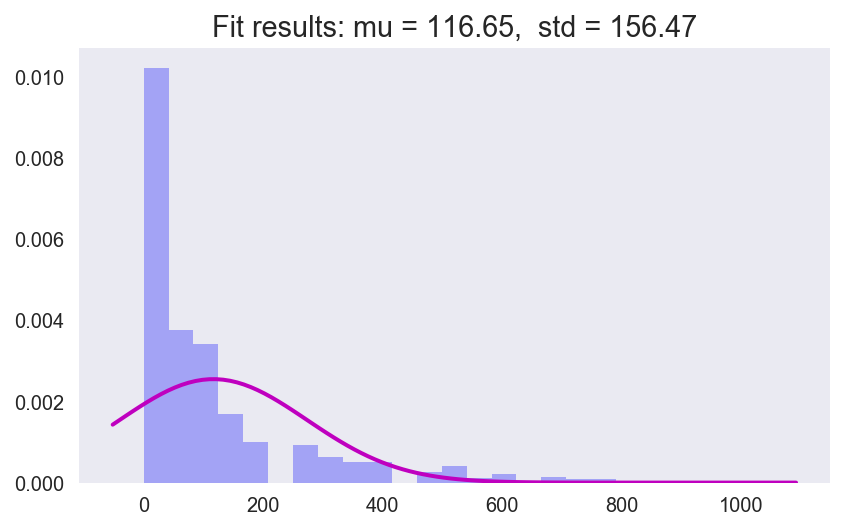

In [74]:
plt.hist(animals['age_in_weeks'], bins=25, normed=True, alpha=0.3, color='b')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, μ, σ)

plt.plot(x, p, 'm', linewidth=2);
title = "Fit results: mu = {:.2f},  std = {:.2f}".format(μ, σ)
plt.title(title);

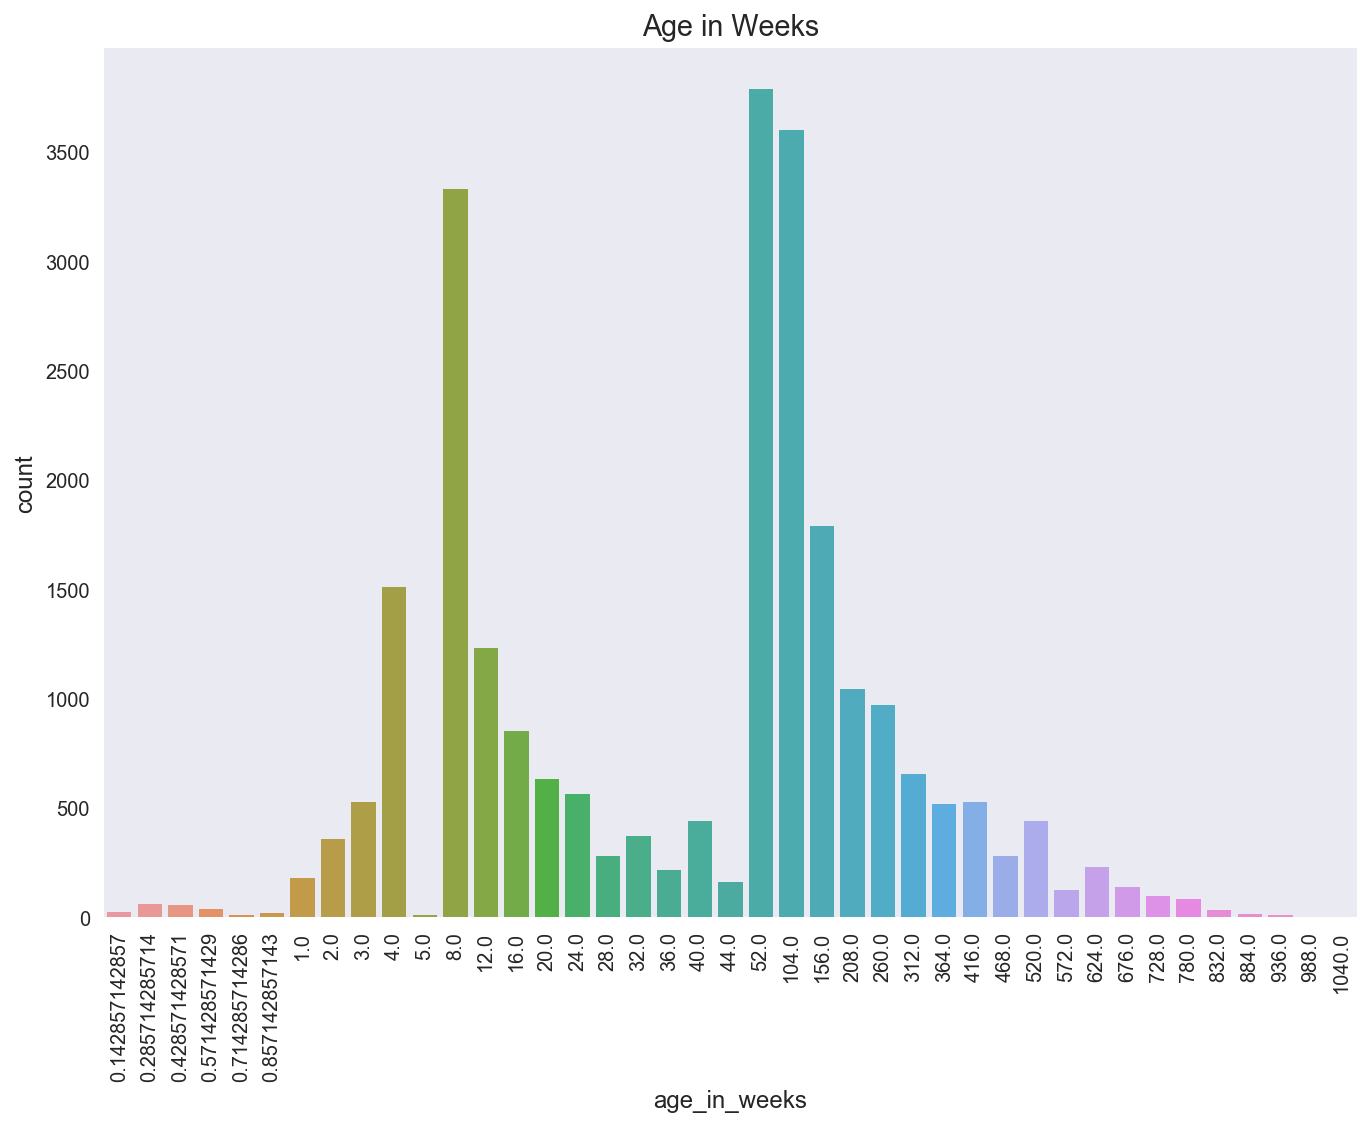

In [239]:
# fit the bimodal using 2 different distributions - the first half is a normal distribution... 
# the second can be fit with power law distribution (Zipf's law)
plt.subplots(figsize=(10,8))
sns.countplot(animals.age_in_weeks, 
              data=animals).set_title('Age in Weeks')
plt.xticks(rotation=90);

In [76]:
model_age = smf.logit(formula='adopted ~ dog + has_name + pop_name + sex + spay_neutered + day + month + time_of_day + season + age_in_weeks', data=animals).fit()
model_age.summary()

Optimization terminated successfully.
         Current function value: 0.497858
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                adopted   No. Observations:                25248
Model:                          Logit   Df Residuals:                    25234
Method:                           MLE   Df Model:                           13
Date:                Fri, 10 Mar 2017   Pseudo R-squ.:                  0.2699
Time:                        12:01:13   Log-Likelihood:                -12570.
converged:                       True   LL-Null:                       -17216.
                                        LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
Intercept                 -3.4807      0.481     -7.231      0.000        -4.424    -2.537
time_of_day[T.evening]    -0.0045      0.265     -0.017      0.987        -0.523     0.514
time_of_day[T.morning]     0.2065      0.240      0.859      0.391        -0.265     0.678
season[T.spring]           0.0320      0.141      0.227      0.820        -0.244     0.308
season[T.summer]           0.3178      0.087      3.638      0.000         0.147     0.489
season[T.winter]           0.3177      0.196      1.624      0.104        -0.066     0.701
dog                       -0.4534      0.034    -13.163      0.000        -0.521    -0.386
has_name                   0.3066      0.043      7.143      0.000         0.222     0.391
pop_name                  -0.1025      0.075     -1.361      0.174        -0.250     0.045
sex                        0.2298      0.031      7.437      0.000         0.169     0.290
spay_neutered              3.6047      0.062     58.283      0.000         3.483     3.726
day                        0.1346      0.008     17.915      0.000         0.120     0.149
month                     -0.0053      0.024     -0.218      0.827        -0.053     0.043
age_in_weeks              -0.0046      0.000    -38.226      0.000        -0.005    -0.004
==========================================================================================
"""

### Color

358 different colors for animal's fur/coat!! Needs to be simplified into something more reasonable. My plan of action is to get the column/series as a list of all the colors, get all the unique colors and cast that to a new dataframe with adoptions and the original color column. From there I use a correlation matrix to find the top 10 colors that are the most correlated with adoptions.

In [77]:
len(animals.color.value_counts(dropna=True))

358

In [78]:
value_counts = animals.color.value_counts()
print(len(value_counts[value_counts > 500]))
value_counts[value_counts > 500]

16


Black/White          2658
Black                2053
Brown Tabby          1428
White                 879
Brown/White           877
Brown Tabby/White     829
Tan/White             757
Orange Tabby          750
Tricolor              740
Black/Tan             663
Blue/White            663
Brown                 617
Tan                   609
White/Black           598
White/Brown           554
Tortie                509
Name: color, dtype: int64

In [79]:
# turn rows of string to rows of lists
animals['color_list'] = animals.color.apply(lambda row: row.split('/'))

In [80]:
animals['color_list'].head(10)

0    [Brown, White]
1     [Cream Tabby]
2     [Blue, White]
3      [Blue Cream]
4             [Tan]
5      [Black, Tan]
6      [Blue Tabby]
7      [Red, White]
8           [White]
9          [Silver]
Name: color_list, dtype: object

In [81]:
def multi_color(row):
    """returns indicator variable for multi_colored coats"""
    if len(row) >= 2 or 'Tricolor' in row:
        multi = 1
    else:
        multi = 0
    return multi

assert multi_color('Tricolor') == 1

In [82]:
animals['mutli_color'] = animals.color_list.apply(multi_color)

In [83]:
colors = [color for color_list in animals.color_list for color in color_list]

unique_colors = list(set(colors))

print(len(unique_colors))
unique_colors[:10]

57


['Silver Tabby',
 'Fawn',
 'Calico Point',
 'Buff',
 'Blue Cream',
 'Agouti',
 'Liver Tick',
 'Blue Point',
 'Ruddy',
 'Tortie']

In [84]:
simple_colors = [color for phrases in unique_colors for color in phrases.split()]

In [85]:
simple_colors = list(set(simple_colors))
len(simple_colors)

36

In [86]:
simple_colors

['Fawn',
 'Flame',
 'Buff',
 'Agouti',
 'Ruddy',
 'Tortie',
 'White',
 'Tick',
 'Apricot',
 'Cream',
 'Blue',
 'Calico',
 'Tricolor',
 'Merle',
 'Chocolate',
 'Silver',
 'Gold',
 'Black',
 'Lilac',
 'Red',
 'Pink',
 'Point',
 'Tabby',
 'Tan',
 'Brindle',
 'Brown',
 'Seal',
 'Torbie',
 'Orange',
 'Lynx',
 'Gray',
 'Smoke',
 'Tiger',
 'Yellow',
 'Sable',
 'Liver']

In [87]:
simple_colors.remove('Point')
simple_colors.remove('Tick')
simple_colors.remove('Tricolor')

Below I essentially try to find the most important breed with "correlation" hacking...

In [88]:
color_imp = animals[['adopted', 'color_list']]
color_imp.head()

,adopted,color_list
0,0,"[Brown, White]"
1,0,[Cream Tabby]
2,1,"[Blue, White]"
3,0,[Blue Cream]
4,0,[Tan]


In [89]:
for color in simple_colors:
    color_imp[color] = animals.color_list.map(lambda row: 1 if color in row else 0)

/Users/VanessaG/anaconda3/envs/stats/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [90]:
color_imp.columns

Index(['adopted', 'color_list', 'Fawn', 'Flame', 'Buff', 'Agouti', 'Ruddy',
       'Tortie', 'White', 'Apricot', 'Cream', 'Blue', 'Calico', 'Merle',
       'Chocolate', 'Silver', 'Gold', 'Black', 'Lilac', 'Red', 'Pink', 'Tabby',
       'Tan', 'Brindle', 'Brown', 'Seal', 'Torbie', 'Orange', 'Lynx', 'Gray',
       'Smoke', 'Tiger', 'Yellow', 'Sable', 'Liver'],
      dtype='object')

In [91]:
color_imp.head()

,adopted,color_list,Fawn,Flame,Buff,Agouti,Ruddy,Tortie,White,Apricot,...,Seal,Torbie,Orange,Lynx,Gray,Smoke,Tiger,Yellow,Sable,Liver
0,0,"[Brown, White]",0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,[Cream Tabby],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,"[Blue, White]",0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,[Blue Cream],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,[Tan],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [92]:
color_imp.describe()

,adopted,Fawn,Flame,Buff,Agouti,Ruddy,Tortie,White,Apricot,Cream,...,Seal,Torbie,Orange,Lynx,Gray,Smoke,Tiger,Yellow,Sable,Liver
count,25248.000000,25248.000000,25248.0,25248.000000,25248.000000,25248.000000,25248.00000,25248.000000,25248.000000,25248.000000,...,25248.0,25248.000000,25248.000000,25248.0,25248.000000,25248.0,25248.0,25248.000000,25248.000000,25248.000000
mean,0.425063,0.008199,0.0,0.012714,0.000079,0.000040,0.02222,0.459522,0.001149,0.011367,...,0.0,0.014892,0.002812,0.0,0.013308,0.0,0.0,0.009308,0.012674,0.001069
std,0.494362,0.090176,0.0,0.112039,0.008900,0.006293,0.14740,0.498369,0.033872,0.106012,...,0.0,0.121124,0.052956,0.0,0.114592,0.0,0.0,0.096028,0.111867,0.032685
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
max,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,...,0.0,1.000000,1.000000,0.0,1.000000,0.0,0.0,1.000000,1.000000,1.000000


In [93]:
animals.color.value_counts().head(10)

Black/White          2658
Black                2053
Brown Tabby          1428
White                 879
Brown/White           877
Brown Tabby/White     829
Tan/White             757
Orange Tabby          750
Tricolor              740
Black/Tan             663
Name: color, dtype: int64

In [94]:
color_imp.corr()['adopted'].sort_values(ascending=False)[:11]

adopted    1.000000
Sable      0.020756
White      0.008909
Tan        0.007744
Ruddy      0.007319
Buff       0.006833
Tortie     0.005729
Black      0.004729
Brown      0.001535
Agouti     0.001349
Torbie     0.000778
Name: adopted, dtype: float64

In [95]:
# add these 10 colors back to animals dataframe as columns...

In [96]:
top10_colors = [color for color in color_imp.corr()['adopted'].sort_values(ascending=False).index[:11] if color != 'adopted']

In [97]:
for color in top10_colors:
    animals[color] = animals.color_list.map(lambda row: 1 if color in row else 0)

In [98]:
animals.head(3)

,id,name,date_outcome,outcome,outcome_info,animal,sex_outcome,age,breed,color,...,Sable,White,Tan,Ruddy,Buff,Tortie,Black,Brown,Agouti,Torbie
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,...,0,1,0,0,0,0,0,1,0,0
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,...,0,0,0,0,0,0,0,0,0,0
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,...,0,1,0,0,0,0,0,0,0,0


In [99]:
animals.Torbie.value_counts()

0    24872
1      376
Name: Torbie, dtype: int64

In [100]:
count = 0
for row in animals.color:
    if "Torbie" in row:
        count += 1
count        

376

In [101]:
animals.columns

Index(['id', 'name', 'date_outcome', 'outcome', 'outcome_info', 'animal',
       'sex_outcome', 'age', 'breed', 'color', 'dog', 'adopted', 'has_name',
       'pop_name', 'sex', 'spay_neutered', 'datetime', 'day', 'month', 'year',
       'hour', 'minutes', 'time_of_day', 'season', 'age_in_weeks',
       'color_list', 'mutli_color', 'Sable', 'White', 'Tan', 'Ruddy', 'Buff',
       'Tortie', 'Black', 'Brown', 'Agouti', 'Torbie'],
      dtype='object')

In [105]:
# Pseudo R-squared keeps going up obviously as I add variables
model_color = smf.logit(formula='adopted ~ dog + has_name + pop_name + sex +'\
                      'spay_neutered + day + month + time_of_day + season +'\
                      'age_in_weeks + mutli_color + Sable + White + Tan + Ruddy +'\
                    'Buff + Tortie + Black + Brown + Agouti + Torbie', data=animals).fit()
model_color.summary()

         Current function value: 0.497406
         Iterations: 35


/Users/VanessaG/anaconda3/envs/stats/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                adopted   No. Observations:                25248
Model:                          Logit   Df Residuals:                    25223
Method:                           MLE   Df Model:                           24
Date:                Fri, 10 Mar 2017   Pseudo R-squ.:                  0.2705
Time:                        12:03:19   Log-Likelihood:                -12558.
converged:                      False   LL-Null:                       -17216.
                                        LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
Intercept                 -3.5242      0.482     -7.313      0.000        -4.469    -2.580
time_of_day[T.evening]     0.0236      0.265      0.089      0.929        -0.496     0.543
time_of_day[T.morning]     0.2317      0.241      0.962      0.336        -0.240     0.704
season[T.spring]           0.0455      0.141      0.322      0.747        -0.231     0.322
season[T.summer]           0.3247      0.087      3.713      0.000         0.153     0.496
season[T.winter]           0.3376      0.196      1.724      0.085        -0.046     0.722
dog                       -0.4983      0.040    -12.449      0.000        -0.577    -0.420
has_name                   0.3119      0.043      7.253      0.000         0.228     0.396
pop_name                  -0.1043      0.075     -1.385      0.166        -0.252     0.043
sex                        0.2384      0.031      7.575      0.000         0.177     0.300
spay_neutered              3.6053      0.062     58.281      0.000         3.484     3.727
day                        0.1345      0.008     17.878      0.000         0.120     0.149
month                     -0.0026      0.024     -0.108      0.914        -0.051     0.045
age_in_weeks              -0.0046      0.000    -38.163      0.000        -0.005    -0.004
mutli_color                0.0801      0.048      1.682      0.093        -0.013     0.173
Sable                      0.4265      0.136      3.125      0.002         0.159     0.694
White                     -0.0911      0.045     -2.046      0.041        -0.178    -0.004
Tan                        0.0261      0.051      0.508      0.611        -0.075     0.127
Ruddy                     14.5876   1887.082      0.008      0.994     -3684.024  3713.199
Buff                       0.2499      0.134      1.860      0.063        -0.013     0.513
Tortie                    -0.1634      0.119     -1.372      0.170        -0.397     0.070
Black                     -0.0060      0.037     -0.165      0.869        -0.078     0.066
Brown                      0.0185      0.051      0.364      0.716        -0.081     0.118
Agouti                    -1.1866      1.416     -0.838      0.402        -3.963     1.590
Torbie                    -0.0459      0.147     -0.313      0.755        -0.333     0.242
==========================================================================================
"""

### Breed

In [106]:
print(len(animals.breed.value_counts()))
value_counts = animals.breed.value_counts()
print(len(value_counts[value_counts > 100]))
value_counts[value_counts > 100]

1371
25


Domestic Shorthair Mix       7782
Pit Bull Mix                 1876
Chihuahua Shorthair Mix      1726
Labrador Retriever Mix       1322
Domestic Medium Hair Mix      786
German Shepherd Mix           570
Domestic Longhair Mix         482
Siamese Mix                   368
Australian Cattle Dog Mix     362
Dachshund Mix                 309
Boxer Mix                     233
Miniature Poodle Mix          231
Border Collie Mix             214
Australian Shepherd Mix       158
Catahoula Mix                 155
Rat Terrier Mix               153
Jack Russell Terrier Mix      144
Yorkshire Terrier Mix         141
Chihuahua Longhair Mix        138
Siberian Husky Mix            135
Miniature Schnauzer Mix       133
Domestic Shorthair            133
Beagle Mix                    123
Rottweiler Mix                110
American Bulldog Mix          109
Name: breed, dtype: int64

In [107]:
animals['mixed_breed'] = animals.breed.apply(lambda row: \
                                             1 if '/' in row or 'mix' in row.lower() else 0)

In [108]:
animals[['breed','mixed_breed']].head(10)

,breed,mixed_breed
0,Shetland Sheepdog Mix,1
1,Domestic Shorthair Mix,1
2,Pit Bull Mix,1
3,Domestic Shorthair Mix,1
4,Lhasa Apso/Miniature Poodle,1
5,Cairn Terrier/Chihuahua Shorthair,1
6,Domestic Shorthair Mix,1
7,American Pit Bull Terrier Mix,1
8,Cairn Terrier,0
9,Miniature Schnauzer Mix,1


In [109]:
animals['breed_list'] = animals.breed.apply(lambda row: row.split('/'))

In [110]:
animals.columns

Index(['id', 'name', 'date_outcome', 'outcome', 'outcome_info', 'animal',
       'sex_outcome', 'age', 'breed', 'color', 'dog', 'adopted', 'has_name',
       'pop_name', 'sex', 'spay_neutered', 'datetime', 'day', 'month', 'year',
       'hour', 'minutes', 'time_of_day', 'season', 'age_in_weeks',
       'color_list', 'mutli_color', 'Sable', 'White', 'Tan', 'Ruddy', 'Buff',
       'Tortie', 'Black', 'Brown', 'Agouti', 'Torbie', 'mixed_breed',
       'breed_list'],
      dtype='object')

In [111]:
animals['breed_list'].head()

0           [Shetland Sheepdog Mix]
1          [Domestic Shorthair Mix]
2                    [Pit Bull Mix]
3          [Domestic Shorthair Mix]
4    [Lhasa Apso, Miniature Poodle]
Name: breed_list, dtype: object

In [112]:
breeds = [breed for breed_list in animals.breed_list for breed in breed_list]
unique_breeds = list(set(breeds))
print(len(unique_breeds))
unique_breeds

397


['Finnish Spitz',
 'Schipperke Mix',
 'Siberian Husky Mix',
 'Pixiebob Shorthair Mix',
 'Italian Greyhound Mix',
 'Greyhound',
 'Akita Mix',
 'St. Bernard Rough Coat',
 'Pbgv',
 'Bruss Griffon',
 'Rottweiler',
 'Bullmastiff Mix',
 'Bulldog Mix',
 'Miniature Poodle Mix',
 'Vizsla Mix',
 'Spanish Water Dog',
 'Norwich Terrier',
 'Redbone Hound',
 'Parson Russell Terrier',
 'Whippet',
 'Blue Lacy',
 'Maine Coon Mix',
 'Silky Terrier Mix',
 'Staffordshire Mix',
 'Jindo Mix',
 'Boxer',
 'Persian Mix',
 'Tibetan Terrier Mix',
 'Collie Rough Mix',
 'Newfoundland',
 'Boston Terrier Mix',
 'British Shorthair Mix',
 'Blue Lacy Mix',
 'Norfolk Terrier',
 'Belgian Sheepdog Mix',
 'German Pinscher',
 'Cavalier Span Mix',
 'Plott Hound',
 'Affenpinscher Mix',
 'American Foxhound',
 'Collie Smooth',
 'English Foxhound Mix',
 'Welsh Terrier',
 'Beagle Mix',
 'Standard Poodle',
 'Old English Bulldog Mix',
 'German Pinscher Mix',
 'Jack Russell Terrier',
 'Staffordshire',
 'Catahoula',
 'Tibetan Spaniel

In [113]:
simple_breeds = [breed for phrases in unique_breeds for breed in phrases.split()]

In [114]:
simple_breeds = list(set(simple_breeds))
len(simple_breeds)

262

In [115]:
animals.shape

(25248, 39)

In [116]:
breed_imp = animals[['adopted', 'breed']]
breed_imp.head()

,adopted,breed
0,0,Shetland Sheepdog Mix
1,0,Domestic Shorthair Mix
2,1,Pit Bull Mix
3,0,Domestic Shorthair Mix
4,0,Lhasa Apso/Miniature Poodle


In [117]:
for breed in simple_breeds:
    breed_imp[breed] = animals.breed.map(lambda row: 1 if breed in row else 0)

/Users/VanessaG/anaconda3/envs/stats/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [118]:
breed_imp.head(2)

,adopted,breed,Saluki,Bullmastiff,Plott,Afghan,Schipperke,Foxhound,West,Longhair,...,Leonberger,Basenji,Vallhund,Highland,Tibetan,Terrier,Spinone,Of,Cavalier,Kelpie
0,0,Shetland Sheepdog Mix,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,Domestic Shorthair Mix,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [119]:
animals.breed.value_counts().head(10)

Domestic Shorthair Mix       7782
Pit Bull Mix                 1876
Chihuahua Shorthair Mix      1726
Labrador Retriever Mix       1322
Domestic Medium Hair Mix      786
German Shepherd Mix           570
Domestic Longhair Mix         482
Siamese Mix                   368
Australian Cattle Dog Mix     362
Dachshund Mix                 309
Name: breed, dtype: int64

In [120]:
breed_imp.corr()['adopted'].sort_values(ascending=False)[:11]

adopted       1.000000
Chihuahua     0.030635
Cat           0.028809
Dachshund     0.027136
Collie        0.026926
Border        0.026826
Australian    0.026256
Cairn         0.026186
Welsh         0.025219
Labrador      0.024432
Catahoula     0.023550
Name: adopted, dtype: float64

In [121]:
top10_breeds = [breed for breed in breed_imp.corr()['adopted'].sort_values(ascending=False).index[:11] if color != 'adopted']

In [122]:
for breed in top10_breeds:
    animals[breed] = animals.breed.map(lambda row: 1 if breed in row else 0)

In [123]:
animals.shape

(25248, 49)

In [124]:
animals.Labrador.value_counts()

0    23028
1     2220
Name: Labrador, dtype: int64

In [125]:
count = 0
for row in animals.breed:
    if "Labrador" in row:
        count += 1
count        

2220

In [129]:
# This results in a "PerfectSeparationError"

# model_breed = smf.logit(formula='adopted ~ dog + has_name + pop_name + sex +'\
#                       'spay_neutered + day + month + time_of_day + season +'\
#                       'age_in_weeks + mutli_color + Sable + White + Tan + Ruddy +'\
#                     'Buff + Tortie + Black + Brown + Agouti + Torbie +'\
#                     'mixed_breed + Chihuahua + Cat + Dachshund + Collie + Border + Australian + Cairn + Welsh + Labrador + Catahoula', data=animals).fit()
# model_breed.summary()

# Modeling

In [130]:
animals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25248 entries, 0 to 25247
Data columns (total 49 columns):
id               25248 non-null object
name             25248 non-null object
date_outcome     25248 non-null object
outcome          25248 non-null object
outcome_info     11708 non-null object
animal           25248 non-null object
sex_outcome      25248 non-null object
age              25248 non-null object
breed            25248 non-null object
color            25248 non-null object
dog              25248 non-null int64
adopted          25248 non-null int64
has_name         25248 non-null int64
pop_name         25248 non-null int64
sex              25248 non-null int64
spay_neutered    25248 non-null int64
datetime         25248 non-null datetime64[ns]
day              25248 non-null int64
month            25248 non-null int64
year             25248 non-null int64
hour             25248 non-null float64
minutes          25248 non-null int64
time_of_day      25248 non-null ob

In [152]:
cols_remove = ['outcome_info','day','datetime','year','hour','minutes','color_list','breed_list', 'spay_neutered', 'month']
cols_keep = [col for col in animals.columns if type(animals[col][0]) != str and col not in cols_remove]

In [153]:
animals_predictors = animals[cols_keep]

In [154]:
animals_predictors.columns

Index(['dog', 'adopted', 'has_name', 'pop_name', 'sex', 'age_in_weeks',
       'mutli_color', 'Sable', 'White', 'Tan', 'Ruddy', 'Buff', 'Tortie',
       'Black', 'Brown', 'Agouti', 'Torbie', 'mixed_breed', 'Chihuahua', 'Cat',
       'Dachshund', 'Collie', 'Border', 'Australian', 'Cairn', 'Welsh',
       'Labrador', 'Catahoula'],
      dtype='object')

In [155]:
predictors = [col for col in animals_predictors.columns if col != 'adopted']
target = 'adopted'

In [156]:
formula1 = target + ' ~ ' + ' + '.join(predictors) 

In [157]:
formula1

'adopted ~ dog + has_name + pop_name + sex + age_in_weeks + mutli_color + Sable + White + Tan + Ruddy + Buff + Tortie + Black + Brown + Agouti + Torbie + mixed_breed + Chihuahua + Cat + Dachshund + Collie + Border + Australian + Cairn + Welsh + Labrador + Catahoula'

In [240]:
# model1 = smf.logit(formula=formula1, data=animals_predictors).fit()